In [41]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy as copy
import datetime
import json
from math import ceil
import multiprocessing
import logging
import operator
import os
import random
import time
import typing
import warnings

import joblib
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.core.numeric import outer
import pandas as pd
from scipy.stats import mode, entropy
import seaborn as sns
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import sklearn.model_selection
import typer
from tqdm.auto import tqdm

import src

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
iterator = [(max_depth, fold) for max_depth in np.arange(1, 11) for fold in range(5)]

In [ ]:
def run_model(X: pd.DataFrame, y: pd.Series, s: pd.Series) -> pd.Series:
    ys = y.astype(str) + s.astype(int).astype(str)
    
    skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
    probs = {}
    
    for train_index, test_index in tqdm(skf.split(X=X, y=ys), total=5):
        ships_train = X.iloc[train_index].index
        ships_test = X.iloc[test_index].index

        X_train, X_test = X.loc[ships_train], X.loc[ships_test]
        y_train, y_test = y.loc[ships_train], y.loc[ships_test]
        s_train, s_test = s.loc[ships_train], s.loc[ships_test]

        X_train = np.ascontiguousarray(X_train.values)
        y_train = np.ascontiguousarray(y_train.values.ravel())
        s_train = np.ascontiguousarray(s_train.values.ravel())
        X_test = np.ascontiguousarray(X_test.values)
        y_test = np.ascontiguousarray(y_test.values.ravel())
        s_test = np.ascontiguousarray(s_test.values.ravel())

        vt = sklearn.feature_selection.VarianceThreshold()
        vt.fit(X_train)
        X_train = vt.transform(X_train)
        X_test = vt.transform(X_test) 

        clf = sklearn.ensemble.RandomForestClassifier(max_depth=5)    
        clf.fit(X_train, y_train, s_train)
        probs_this_fold = clf.predict_proba(X_test)
        for ship, prob in zip(ships_test, probs_this_fold):
            probs[ship] = prob[1]
    
    y_score = pd.Series(probs).loc[X.index]
    return y_score


# ML model

In [8]:
results = {}

## Strategy A

### With portstay

In [9]:
X, y, s = src.get_Xys()
y_true = y > 1

# RUN
y_score = run_model(X, y_true, s)
results[('A', True)] = src.get_results(y_true, y_score)

  0%|          | 0/5 [00:00<?, ?it/s]

### Without portstay

In [10]:
X, y, s = src.get_Xys()
X.drop(columns='port_stay', inplace=True)
assert X.shape[1] == 493
y_true = y > 1

# RUN
y_score = run_model(X, y_true, s)
results[('A', False)] = src.get_results(y_true, y_score)

  0%|          | 0/5 [00:00<?, ?it/s]

## Strategy B

### With portstay

In [11]:
X, y, s = src.get_Xys()
y_true = y>0

# RUN
y_score = run_model(X, y_true, s)
results[('B', True)] = src.get_results(y_true, y_score)

  0%|          | 0/5 [00:00<?, ?it/s]

### Without portstay

In [12]:
X, y, s = src.get_Xys()
X.drop(columns='port_stay', inplace=True)
assert X.shape[1] == 493
y_true = y>0

# RUN
y_score = run_model(X, y_true, s)
results[('B', False)] = src.get_results(y_true, y_score)

  0%|          | 0/5 [00:00<?, ?it/s]

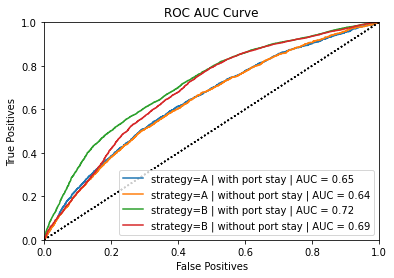

In [13]:
plt.title('ROC AUC Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positives')
plt.ylabel('True Positives')
for idx, (key, value) in enumerate(results.items()):
    ax = plt.subplot(1, 1, 1)
    auc = value['roc_auc_score']
    fpr = value['fpr']
    tpr = value['tpr']
    label = f'strategy={key[0]} | {"with port stay" if key[1] else "without port stay"} | AUC = {auc:.2f}'
    ax.plot(fpr, tpr, label=label)
    ax.plot((0,1), (0, 1), color='black', ls=':')
    ax.legend()

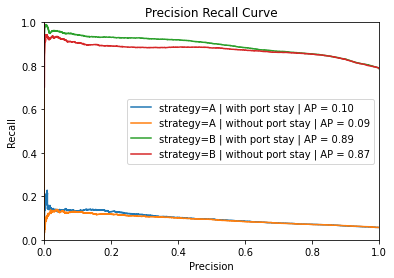

In [14]:
plt.title('Precision Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Precision')
plt.ylabel('Recall')
for idx, (key, value) in enumerate(results.items()):
    ap = value['average_precision_score']
    precision = value['precision']
    recall = value['recall']
    label = f'strategy={key[0]} | {"with port stay" if key[1] else "without port stay"} | AP = {ap:.2f}'
    plt.plot(recall, precision, label=label)
plt.legend()